<h1>Coursera Capstone Project</h1>

<h2>Problem Description</h2>

Many people want to analyze the stock by neural networks:
<br>1. Develop FNN, standard RNN, GRU and LSTM models to the price data. 
<br>2. Tune the hyperparameters using the validation set approach.
<br>3. Predict stock prices in 2019. Check the prediction performance.

<h2>Data</h2>

Consider daily price data from Jan 2, 2016 to Dec 31, 2019 and use year 2019 for testing.
<br>*Stock data is downloaded from Yahoo Finance.

<h2>Python Code</h2>

Import libraries.

In [1]:
import datetime as dtm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
import torch.optim as optim

Neural networks class definition.

In [2]:
class FNN_net(torch.nn.Module):
    def __init__(self, feature_size, hidden_size1, hidden_size2, output_size):
        super(FNN_net, self).__init__()

        self.hidden1 = torch.nn.Linear(feature_size, hidden_size1)  # Hidden layer 1
        self.hidden2 = torch.nn.Linear(hidden_size1, hidden_size2)  # Hidden layer 2
        self.output = torch.nn.Linear(hidden_size2, output_size)    # Output layer
        self.feature_size = feature_size

    def forward(self, x):
        x = torch.relu_(self.hidden1(x))
        x = torch.relu_(self.hidden2(x))
        x = self.output(x)
        return x

class RNN_net(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size):
        super(RNN_net, self).__init__()

        self.rnn = torch.nn.RNN(input_size = feature_size, hidden_size = hidden_size, num_layers = 1, batch_first = True)  # RNN layer
        self.output = torch.nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(2))
        x = self.output(x[:, -1, :])
        return x

class GRU_net(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size):
        super(GRU_net, self).__init__()

        self.rnn = torch.nn.GRU(input_size = feature_size, hidden_size = hidden_size, num_layers = 1, batch_first = True)  # RNN layer
        self.output = torch.nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(2))
        x = self.output(x[:, -1, :])
        return x

class LSTM_net(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()

        self.rnn = torch.nn.LSTM(input_size = feature_size, hidden_size = hidden_size, num_layers = 1, batch_first = True)  # RNN layer
        self.output = torch.nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(2))
        x = self.output(x[:, -1, :])
        return x

Function definition

In [3]:
criterion = torch.nn.MSELoss()

def train(model, num_epoch, dataloader):
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    loss_train_list = []  # record training loss
    loss_vali_list = []   # record validation loss

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        batch_num = 0

        for _, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
#             print(inputs.shape, labels.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)  # forward propagation, get outputs
#             print(outputs.squeeze())
#             print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)  # get loss
            loss.backward()  # back propagation, get gradients of loss
            optimizer.step()  # optimize one step

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]

        loss_train = running_loss / batch_num
        loss_vali = test(model, dl_validation_data)
#         print('[%4d] train loss %.5f | validation loss %.5f' %
#               (epoch+1, loss_train, loss_vali))

        loss_train_list.append(loss_train)
        loss_vali_list.append(loss_vali)

    print('Finished Training')
    return loss_train_list, loss_vali_list

def test(model, dataloader):
    with torch.no_grad():
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)  # forward propagation, get outputs
            loss = criterion(outputs, labels)  # get loss

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]
    return (running_loss / batch_num)

Load data

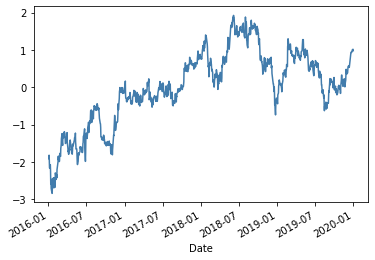

In [10]:
df_stock_data = pd.read_csv('final-project.csv')[["Date", "Adj Close"]]
df_stock_data["Date"] = pd.to_datetime(df_stock_data["Date"])
df_stock_data.set_index("Date", inplace = True)

ax = plt.axes()

#   Normalization
df_stock_data_norm = (df_stock_data - np.mean(df_stock_data)) / np.std(df_stock_data)
df_stock_data_norm['Adj Close'].plot(color = "#427CAC")

Train test split

In [11]:
slice_line_1 = round(df_stock_data_norm.shape[0] * 0.8)
slice_line_2 = round(df_stock_data_norm.shape[0] * 0.9)
narray_training_data = df_stock_data_norm.iloc[ : slice_line_1].to_numpy()
narray_validation_data = df_stock_data_norm.iloc[slice_line_1 : slice_line_2].to_numpy()
narray_testing_data = df_stock_data_norm.iloc[slice_line_2 : ].to_numpy()

lag = 10

narray_training_data = np.concatenate([narray_training_data[i: i + lag + 1].reshape(1, -1) for i in range(len(narray_training_data) - lag)], 0)
narray_validation_data = np.concatenate([narray_validation_data[i: i + lag + 1].reshape(1, -1) for i in range(len(narray_validation_data) - lag)], 0)
narray_testing_data = np.concatenate([narray_testing_data[i: i + lag + 1].reshape(1, -1) for i in range(len(narray_testing_data) - lag)], 0)

tensor_training_data = torch.from_numpy(narray_training_data).float()
tensor_validation_data = torch.from_numpy(narray_validation_data).float()
tensor_testing_data = torch.from_numpy(narray_testing_data).float()

#   Create Tensor Dataset
td_training_data = Data.TensorDataset(tensor_training_data[:, 0:-1], tensor_training_data[:, -1:])
td_validation_data = Data.TensorDataset(tensor_validation_data[:, 0:-1], tensor_validation_data[:, -1:])
td_testing_data = Data.TensorDataset(tensor_testing_data[:, 0:-1], tensor_testing_data[:, -1:])

#   Create Dataloaders
dl_training_data = Data.DataLoader(td_training_data, batch_size = 256, shuffle = True, num_workers = 0)
dl_validation_data = Data.DataLoader(td_validation_data, batch_size = 32, shuffle = True, num_workers = 0)
dl_testing_data = Data.DataLoader(td_testing_data, batch_size = 32, shuffle = True, num_workers = 0)

Training

Training FNN
Finished Training
Training RNN
Finished Training
Training GRU
Finished Training
Training LSTM
Finished Training


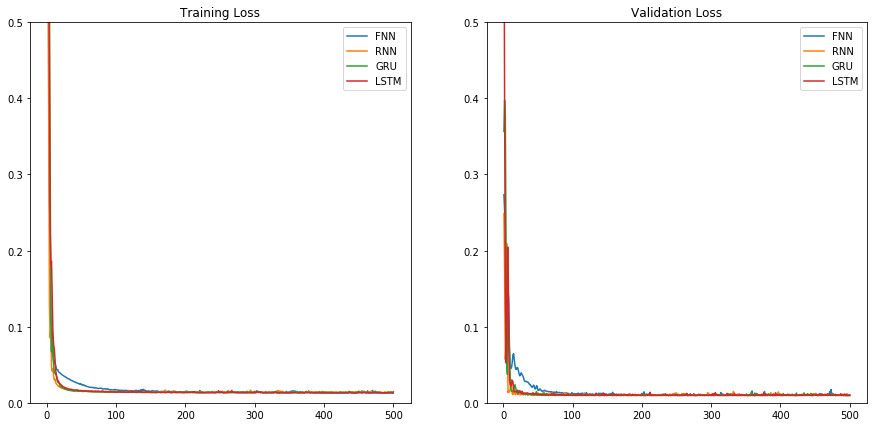

In [12]:
fnn = FNN_net(10, 8, 8, 1)
rnn = RNN_net(1, 8, 1)
gru = GRU_net(1, 8, 1)
lstm = LSTM_net(1, 8, 1)

net_names = ["FNN", "RNN", "GRU", "LSTM"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_title("Training Loss")
ax2.set_title("Validation Loss")
for i, net in enumerate([fnn, rnn, gru, lstm]):
    print("Training", net_names[i])
    loss_train, loss_vali = train(net, 500, dl_training_data)
    ax1.plot(range(1, 1 + len(loss_train)), loss_train, label = net_names[i])
    ax2.plot(range(1, 1 + len(loss_vali)), loss_vali, label = net_names[i])
ax1.set_ylim([0, 0.5])
ax2.set_ylim([0, 0.5])
ax1.legend()
ax2.legend()
#plt.savefig("Loss.png_80_10_10.png", dpi = 150)
plt.show()

Testing

    Net Training Validation  Testing
0   FNN   0.0135    0.00984  0.00948
1   RNN  0.01313    0.01042   0.0085
2   GRU  0.01274    0.00971  0.00904
3  LSTM  0.01473    0.00974  0.00919


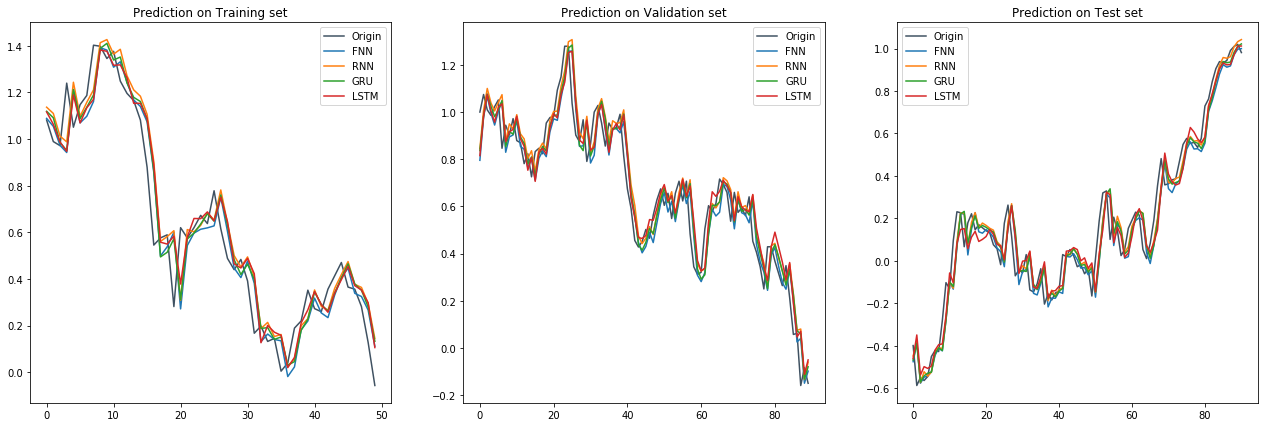

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))
ax1.set_title("Prediction on Training set")
ax2.set_title("Prediction on Validation set")
ax3.set_title("Prediction on Test set")

ax1.plot(tensor_training_data[500 : 550, -1], label = "Origin", color = "#3F5161")
ax2.plot(tensor_validation_data[:, -1], label = "Origin", color = "#3F5161")
ax3.plot(tensor_testing_data[:, -1], label = "Origin", color = "#3F5161")

df_loss_testing = pd.DataFrame(columns = ["Net", "Training", "Validation", "Testing"], index = [0, 1, 2, 3])

count = 0
for i, net in enumerate([rnn, gru, lstm, fnn]):
    ax1.plot(net(tensor_training_data[500 : 550, : -1])[ : , ].squeeze().data.numpy(), label = net_names[i])
    ax2.plot(net(tensor_validation_data[ : , : -1])[ : , 0].squeeze().data.numpy(), label = net_names[i])
    ax3.plot(net(tensor_testing_data[ : , : -1])[ : , 0].squeeze().data.numpy(), label = net_names[i])

    df_loss_testing.iloc[count]["Net"] = net_names[i]
    df_loss_testing.iloc[count]["Training"] = round(test(net, dl_training_data), 5)
    df_loss_testing.iloc[count]["Validation"] = round(test(net, dl_validation_data), 5)
    df_loss_testing.iloc[count]["Testing"] = round(test(net, dl_testing_data), 5)
    count += 1

print(df_loss_testing)
#df_loss_testing.to_csv("Loss_Testing_80_10_10.csv")
ax1.legend()
ax2.legend()
ax3.legend()
#plt.savefig("Prediction_80_10_10.png", dpi = 150)
plt.show()

<h2>Conclusion & Discussion</h2>

In this project, four neural network methodologies peroform quite well to predict the stock price.
<br>However, the lagging problem still cannot be ignored.